### Logistic Regression, ROC Curve, Hyperparameter Tuning, and Confusion Matrix  
---
Logistic Regression is a supervised learning algorithm used for classification, particularly binary classification. It predicts the probability that an input belongs to a certain class using the logistic (sigmoid) function, mapping outputs between 0 and 1. The model is trained by optimizing the log-likelihood function, making it useful for applications like medical diagnosis and fraud detection.  

To evaluate its performance, the **Receiver Operating Characteristic (ROC) curve** is used, which plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various thresholds. The **Area Under the Curve (AUC)** measures overall model performance, with values closer to 1 indicating better discrimination. Additionally, hyperparameter tuning, such as adjusting the regularization strength (`C` in logistic regression), helps improve accuracy and prevent overfitting, often performed using Grid Search or Random Search with cross-validation. Another essential evaluation tool is the **confusion matrix**, which summarizes predictions by displaying True Positives, True Negatives, False Positives, and False Negatives. This matrix helps compute key metrics like precision, recall, and F1-score, offering a deeper understanding of the model's strengths and weaknesses.  

---


**Importing necessary libraries**


---

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.feature_selection import RFE


 Downloading shivadumnawar/titanic dataset


 ---

In [2]:
path = kagglehub.dataset_download("shivadumnawar/titanic-dataset")
df = pd.read_csv(f"{path}/train.csv")

100%|██████████| 33.1k/33.1k [00:00<00:00, 3.66MB/s]

Extracting files...


#Feature Engineering - Extract Title from Name

---

In [3]:
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\\.')
title_replacements = {'Mlle': 'Miss', 'Mme': 'Mrs', 'Ms': 'Miss', 'Dr': 'Rare', 'Rev': 'Rare', 'Col': 'Rare', 'Major': 'Rare'}
df['Title'] = df['Title'].replace(title_replacements)
df['Title'] = df['Title'].apply(lambda x: x if x in ['Mr', 'Miss', 'Mrs', 'Master'] else 'Rare')


Fill Missing Values using KNN Imputer


---
Convert Age and Fare into Bins and Create Family Features


In [4]:
imputer = KNNImputer(n_neighbors=5)
df[['Age', 'Fare']] = imputer.fit_transform(df[['Age', 'Fare']])


df['AgeBin'] = pd.cut(df['Age'], bins=[0, 12, 20, 40, 60, 80], labels=[0, 1, 2, 3, 4])
df['FareBin'] = pd.qcut(df['Fare'], 4, labels=[0, 1, 2, 3])

df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

Drop Unnecessary Columns and Encode Categorical Variables

In [5]:

df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)


df = pd.get_dummies(df, columns=['Sex', 'Embarked', 'Title'], drop_first=True)


 #Define X and y

 ---

In [6]:
 #Define X and y
X = df.drop('Survived', axis=1)
y = df['Survived']

# Train-Test Split with Stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature Selection using RFE
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', solver='saga', penalty='elasticnet', l1_ratio=0.5)
rfe = RFE(log_reg, n_features_to_select=8)
X_train_selected = rfe.fit_transform(X_train_scaled, y_train)
X_test_selected = rfe.transform(X_test_scaled)

Hyperparameter Tuning using GridSearchCV

---

In [7]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'saga'], 'penalty': ['l1', 'l2', 'elasticnet'], 'l1_ratio': [0.1, 0.5, 0.9]}
model = GridSearchCV(LogisticRegression(class_weight='balanced', max_iter=1000), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
model.fit(X_train_selected, y_train)



tuned_model = model.best_estimator_
print(f"Best Parameters: {model.best_params_}")


Best Parameters: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
90 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solve

calculating Predictions, Accuracy and Classification Report

---

In [8]:

y_pred = tuned_model.predict(X_test_selected)


accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')


print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 84.36%
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       110
           1       0.77      0.84      0.81        69

    accuracy                           0.84       179
   macro avg       0.83      0.84      0.84       179
weighted avg       0.85      0.84      0.84       179



 Confusion Matrix

 ---

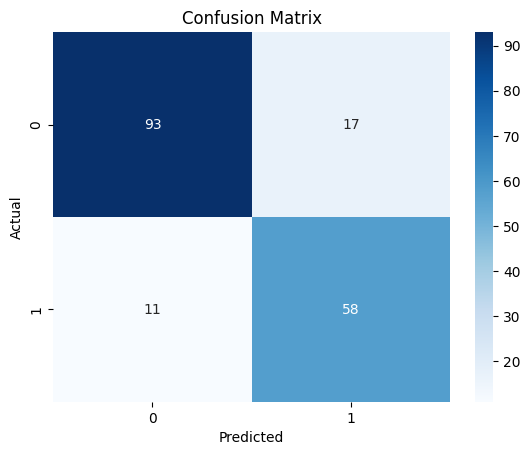

In [9]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



ROC Curve


---

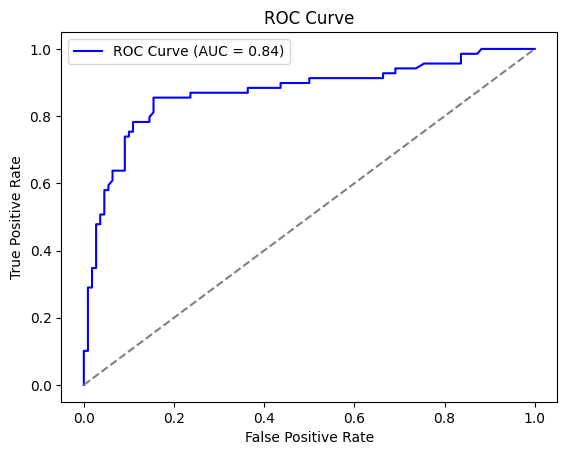

In [10]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, tuned_model.predict_proba(X_test_selected)[:, 1])
roc_auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()